In [1]:
import numpy as np
import sys
import skimage.data
import matplotlib.pyplot as plt
import os

In [2]:
class convolution:
    """
    Convlolution with ReLu
    """
    def __init__(self, num_filters, kernel_size, channels):
        self.num_filters = num_filters #number of filers in the layer
        self.kernel_size = kernel_size #2d shape of kernel
        self.channels = channels #number of channels
        #Random initilization of filter weights
        self.filters = np.random.randn(num_filters, kernel_size, kernel_size, channels) / (kernel_size)**2

    def iterate_image(self, image):
        #channels, height, width
        h, w, c = image.shape
        for i in range(h - self.kernel_size + 1):
            for j in range(w - self.kernel_size + 1):
                im_region = image[i:(i + self.kernel_size), j:(j + self.kernel_size), :]
                yield im_region, i, j
    
    def relu(self, feature_map):
        #Preparing the output of the ReLU activation function.
        relu_out = np.zeros(feature_map.shape)
        for map_num in range(feature_map.shape[-1]):
            for r in np.arange(0,feature_map.shape[0]):
                for c in np.arange(0, feature_map.shape[1]):
                    relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
        return relu_out

    def forward(self, input_image):       
        self.last_input = input_image
        h, w, c = input_image.shape
        output = np.zeros( (h - self.kernel_size + 1, w - self.kernel_size + 1, self.num_filters) )

        for f in range(self.num_filters):
            for im_region, i, j in self.iterate_image(input_image):
                output[i, j, f] = np.sum(im_region * self.filters[f])
        self.relu_out = self.relu(output)
        return self.relu_out #returns output after applying ReLu to the output
    

    def backprop(self, d_L_d_out, learn_rate):
        d_L_d_filters = np.zeros(self.filters.shape)
        for im_region, i, j in self.iterate_image(self.last_input):
            for f in range(self.num_filters):
                if self.relu_out[i, j, f] >= 0: #derivative of ReLu
                    d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

        # Update filters
        self.filters -= learn_rate * d_L_d_filters
        return d_L_d_filters
    
#maxpool of size 2X2 and stride 2
class maxpool:
    """
    Max-Pool of size 2X2 with stride 2
    """
    def iterate_image(self, image):
        h, w, c = image.shape
        new_h = h // 2
        new_w = w // 2
        #pool size of 2 with stride of 2
        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j

    def forward(self, input_image):
        '''
        Performs a forward pass of the maxpool layer using the given input.
        Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
        - input is a 3d numpy array with dimensions (h, w, num_filters)
        '''
        self.last_input = input_image

        h, w, num_filters = input_image.shape
        output = np.zeros((h // 2, w // 2, num_filters))

#         for f in range(num_filters):
        for im_region, i, j in self.iterate_image(input_image):
            output[i, j] = np.amax(im_region, axis=(0, 1))

        return output

    def backprop(self, d_L_d_out):
        '''
        Performs a backward pass of the maxpool layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        '''
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_image(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

        for i2 in range(h):
            for j2 in range(w):
                for f2 in range(f):
                    # If this pixel was the max value, copy the gradient to it.
                    if im_region[i2, j2, f2] == amax[f2]:
                        d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input
    

#Softmax
class softmax:
    def __init__(self, input_len, num_classes):
        
        # Initialize weights randomly
        self.weights = np.random.randn(input_len, num_classes) / input_len
        self.biases = np.zeros(num_classes)

    def forward(self, input_data):
        self.last_input_shape = input_data.shape

        input_data = input_data.flatten()
        self.last_input = input_data
        input_len, nodes = self.weights.shape

        totals = np.dot(input_data, self.weights) + self.biases
        self.last_totals = totals

        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)

    def backprop(self, d_L_d_out, learn_rate):
        '''
        Performs a backward pass of the softmax layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''
        # We know only 1 element of d_L_d_out will be nonzero
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

          # e^totals
            t_exp = np.exp(self.last_totals)

            # Sum of all e^totals
            S = np.sum(t_exp)

            # Gradients of out[i] against totals
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

            # Gradients of totals against weights/biases/input
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            # Gradients of loss against totals
            d_L_d_t = gradient * d_out_d_t

            # Gradients of loss against weights/biases/input
            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t

            # Update weights / biases
            self.weights -= learn_rate * d_L_d_w
            self.biases -= learn_rate * d_L_d_b

            return d_L_d_inputs.reshape(self.last_input_shape)

In [25]:
def forward_prop(image, label, verbose = False):
  
    l1_conv = conv1.forward(img)
    l1_maxpool = pool1.forward(l1_conv)
#     print(l1_maxpool.shape)
    l1_softmax = sf1.forward(l1_maxpool)
    # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
    loss = -np.log(l1_softmax[label])
    acc = 1 if np.argmax(l1_softmax) == label else 0
    
    #=========Layer1 Display after training
    if verbose:
        num_filters = 10
        fig1, ax1 = plt.subplots(nrows=num_filters, ncols=2, figsize=(20,20), dpi=80)
        for f in range(num_filters):
            ax1[f, 0].imshow(l1_conv[:, :, f]).set_cmap("gray")
            ax1[f, 0].get_xaxis().set_ticks([])
            ax1[f, 0].get_yaxis().set_ticks([])
            ax1[f, 0].set_title(f"L1_Convolution-F{f+1}")

            ax1[f, 1].imshow(l1_maxpool[:, :, f]).set_cmap("gray")
            ax1[f, 1].get_xaxis().set_ticks([])
            ax1[f, 1].get_yaxis().set_ticks([])
            ax1[f, 1].set_title(f"L1-MaxPool-F{f+1}")
        plt.show() 
        fig1.savefig("layer.png", bbox_inches="tight") # matplotlib.pyplot.close(fig1)

    return l1_softmax, loss, acc

In [26]:
def train(image, label, lr=.005):
    # Forward
    out, loss, acc = forward_prop(img, label)

    # Calculate initial gradient
    gradient = np.zeros(2) #number of classes = 2
    gradient[label] = -1 / out[label]

    # Backprop
    gradient = sf1.backprop(gradient, lr)
    gradient = pool1.backprop(gradient)
    gradient = conv1.backprop(gradient, lr)

    return loss, acc

# CNN Layer Definition

In [23]:
conv1 = convolution(num_filters=10, kernel_size=3, channels=3)
pool1 = maxpool() # 2 by 2 with stride 2
sf1 = softmax(input_len = 99*99*10, num_classes = 2 )

In [21]:
# X[1].shape

(200, 200, 3)

In [32]:
# ======================================For Testing only
# X, y = train_generator.next()
# img = X[5]
# forward_prop(img, 1, True)
#train(img, 1)
#==========================================

## Loading Binary Dataset: Coloured Image

In [14]:
# Directory with our training dandelion pictures
train_dandelion_dir = os.path.join('data/train/dandelion')
# Directory with our training grass pictures
train_grass_dir = os.path.join('data/train/grass')
# Directory with our validation dandelion pictures
valid_dandelion_dir = os.path.join('data/valid/dandelion')
# Directory with our validation grass pictures
valid_grass_dir = os.path.join('data/valid/grass')
train_dandelion_names = os.listdir(train_dandelion_dir)
print(train_dandelion_names[:10])
train_grass_names = os.listdir(train_grass_dir)
print(train_grass_names[:10])
validation_dandelion_hames = os.listdir(valid_dandelion_dir)
print(validation_dandelion_hames[:10])
validation_grass_names = os.listdir(valid_grass_dir)
print(validation_grass_names[:10])

print('total training dandelion images:', len(os.listdir(train_dandelion_dir)))
print('total training grass images:', len(os.listdir(train_grass_dir)))
print('total validation dandelion images:', len(os.listdir(valid_dandelion_dir)))
print('total validation grass images:', len(os.listdir(valid_grass_dir)))

['00000329.jpg', '00000379.jpg', '00000138.jpg', '00000396.jpg', '00000258.jpg', '00000030.jpg', '00000231.jpg', '00000325.jpg', '00000368.jpg', '00000116.jpg']
['00000329.jpg', '00000379.jpg', '00000138.jpg', '00000396.jpg', '00000258.jpg', '00000030.jpg', '00000231.jpg', '00000325.jpg', '00000368.jpg', '00000116.jpg']
['00000030.jpg', '00000068.jpg', '00000007.jpg', '00000035.jpg', '00000027.jpg', '00000079.jpg', '00000016.jpg', '00000010.jpg', '00000049.jpg', '00000067.jpg']
['00000030.jpg', '00000007.jpg', '00000035.jpg', '00000027.jpg', '00000016.jpg', '00000010.jpg', '00000049.jpg', '00000039.jpg', '00000058.jpg', '00000008.jpg']
total training dandelion images: 500
total training grass images: 499
total validation dandelion images: 92
total validation grass images: 65


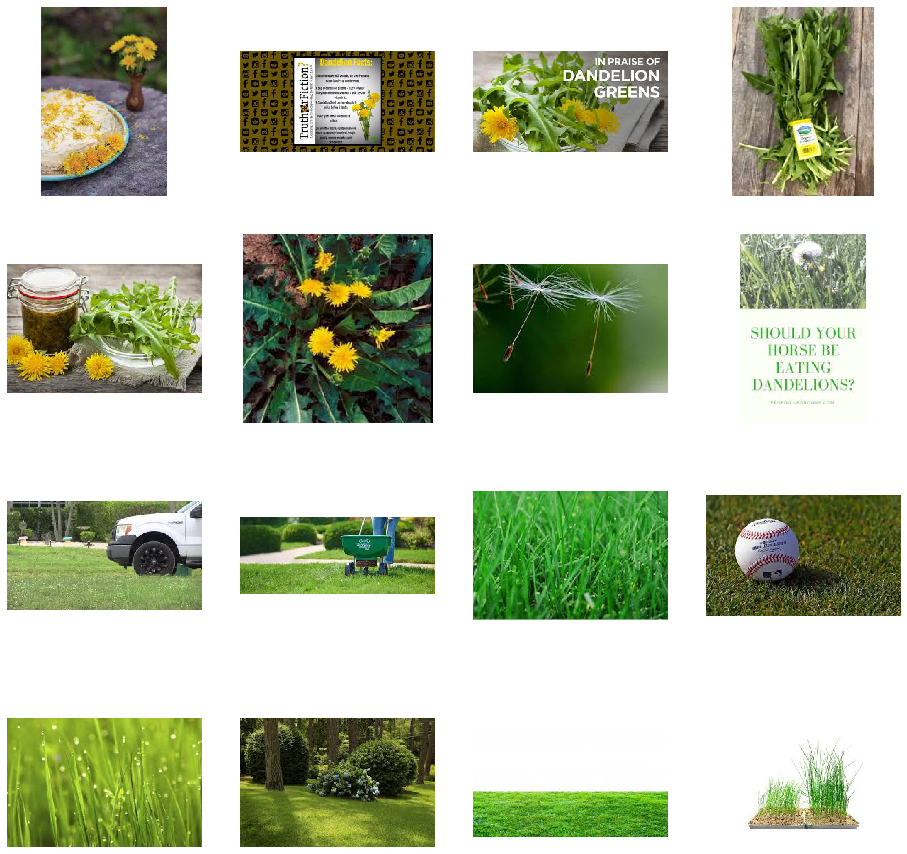

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_dandelion_pic = [os.path.join(train_dandelion_dir, fname) 
                for fname in train_dandelion_names[pic_index-8:pic_index]]
next_grass_pic = [os.path.join(train_grass_dir, fname) 
                for fname in train_grass_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_dandelion_pic + next_grass_pic):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [16]:
#Augment data to increase the images in the dataset.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'data/train/',  # This is the source directory for training images
        classes = ['dandelion', 'grass'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'data/valid/',  # This is the source directory for training images
        classes = ['dandelion', 'grass'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=19,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 999 images belonging to 2 classes.
Found 157 images belonging to 2 classes.


## Train the Model

In [27]:
# Train the CNN for 3 epochs
for epoch in range(1):
    print('--- Epoch %d ---' % (epoch + 1))
    fp = open("accuracy/train_error", "a")
    fp.write(f'--- Epoch {epoch+1} ---')
    
    # Train!
    loss = 0
    num_correct = 0
    for batch in range(train_generator.__len__()):
        X, y = train_generator.next()
        
        # Print for each batch
        print('[Step %d]: Accuracy: %d%%' %(batch, loss / 100, num_correct))
        fp.write(f'\n[Step {batch}]: Accuracy: {num_correct}%')
        loss = 0
        num_correct = 0
        for i, (im, label) in enumerate(zip(X, y)):                            
            l, acc = train(im, int(label))
            loss += l
            num_correct += acc
            print(f"Batch:{batch} | Image:{i}")
fp.close()

--- Epoch 1 ---
[Step 0] Past 100 steps: Average Loss 0.000 | Accuracy: 0%
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
[Step 1] Past 100 steps: Average Loss 69.733 | Accuracy: 55%
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
[Step 2] Past 100 steps: Average Loss 60.710 | Accuracy: 63%
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2

## Test the Model

In [28]:
# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for batch in range(validation_generator.__len__()):
    X, y = validation_generator.next()
    for im, label in zip(X, y):
        _, l, acc = forward_prop(im, int(label))
        loss += l
        num_correct += acc

num_tests = validation_generator.n

print('Test Accuracy:', num_correct / num_tests)
fp = open("accuracy/test_error", "a")
fp.write(f'Test Accuracy: {num_correct / num_tests}')
fp.close()


--- Testing the CNN ---
Test Loss: 59.54810405309097
Test Accuracy: 0.4140127388535032


In [29]:
#========================Layer after training
# X, y = train_generator.next()
# img = X[5]
# forward_prop(img, 0, True)